## <font color='Blue'>Introduction</font>
###  In the practical, we run the example model for evaluation of permebaility field.

## <font color='blue'>The objectives:</font>
1. Introduce custom <font color='red'>'Model'</font> class based on 
 * Class [DartsModel](./darts/models/darts_model.py) with base model capabilities
 * Class [StructReservoir](./darts/models/reservoirs/struct_reservoir.py) with structured reservoir
 * Class [Deadoil](./darts/models/physics/dead_oil_python.py) for basic dead oil physics
 * Class [Deadoil-properties](./darts/models/physics/do_properties_python.py) for dead oil properties, such as density, viscosity and relative permeability
2. Use run_python procedure to control run from the python script
3. Introduce wells and time-dependent well controls
4. Redefine physical properties and run simulation with custom-defined property.

## <font color='Blue'>Let's start!</font>


<font color='Green'>Beer van Esser
1 juni 2021</font>

In [4]:
from darts.models.reservoirs.struct_reservoir import StructReservoir
from darts.models.physics.dead_oil_python import DeadOil
from darts.models.darts_model import DartsModel
from darts.engines import value_vector
from darts.tools.keyword_file_tools import load_single_keyword

import numpy as np
import matplotlib.pyplot as plt

#### Brief Introduction of model inheritance
* Here create the <font color='red'>'Model' </font>  class, which inherits from <font color='red'>DartsModel</font> (the base class).
* It keeps all the functionalities of <font color='red'>DartsModel</font> and can also be extended to add more functionalities.
* If a function is redefined in subclass, the function in base class with identical name will be overridden.

In [5]:
class Model(DartsModel):
    def __init__(self, perm=None, nd = 60, db = 8):
        # call base class constructor
        super().__init__()

        # measure time spend on reading/initialization
        self.timer.node["initialization"].start()

        # create reservoir
        self.nx = nd
        self.ny = nd
        self.nz = 1

        self.dx = db
        self.dy = db
        self.dz = 4

        if (perm is None):
            perm = np.ones(self.nx*self.ny)*3000
        else:
            perm = perm.reshape(self.nx*self.ny)

        self.permx = perm
        self.permy = perm
        self.permz = 0.1 * perm
        self.poro = 0.2
        self.depth = 4000

        # run discretization
        self.reservoir = StructReservoir(self.timer, nx=self.nx, ny=self.ny, nz=self.nz, dx=self.dx, dy=self.dy,
                                         dz=self.dz, permx=self.permx, permy=self.permy, permz=self.permz,
                                         poro=self.poro, depth=self.depth)

        self.ix = np.int32(self.nx / 2)
        self.iy = np.int32(self.ny / 2)

        self.reservoir.add_well("INJ1")
        self.reservoir.add_perforation(self.reservoir.wells[-1], self.ix, self.iy, 1,  well_index=10)

        self.reservoir.add_well("PRD1")
        self.reservoir.add_perforation(self.reservoir.wells[-1], 1, 1, 1, well_index=10)

        self.reservoir.add_well("PRD2")
        self.reservoir.add_perforation(self.reservoir.wells[-1], 1, self.ny, 1, well_index=10)

        self.reservoir.add_well("PRD3")
        self.reservoir.add_perforation(self.reservoir.wells[-1], self.nx, 1, 1, well_index=10)

        self.reservoir.add_well("PRD4")
        self.reservoir.add_perforation(self.reservoir.wells[-1], self.nx, self.ny, 1, well_index=10)

        # create physics
        self.physics = DeadOil(timer=self.timer, physics_filename='physics.in',
                               n_points=401, min_p=300, max_p=600, min_z=1e-8)

        self.params.first_ts = 1
        self.params.mult_ts = 2
        self.params.max_ts = 50
        self.params.tolerance_newton = 1e-2
        self.params.tolerance_linear = 1e-3

        self.inj = [1]

        self.runtime = 1000

        self.timer.node["initialization"].stop()

    def set_initial_conditions(self):
        self.physics.set_uniform_initial_conditions(self.reservoir.mesh, uniform_pressure=400,
                                                    uniform_composition=[0.1])

    def set_boundary_conditions(self):
        for i, w in enumerate(self.reservoir.wells):
            if w.name[:3] == "INJ":
                w.control = self.physics.new_bhp_water_inj(410, self.inj)
                # w.constraint = self.physics.new_rate_water_prod(210)
            else:
                w.control = self.physics.new_bhp_prod(390)

    # This function plots streamlines based on passed pressure solution
    # and permebility map from model class
    def plot_streamline(self, p, array, col='r'):

        P_2D = p.reshape(self.nx, self.ny)
        kx = self.permx.reshape(self.ny, self.nx)
        ky = self.permy.reshape(self.ny, self.nx)
        nvx, nvy = (self.nx-1, self.ny-1)

        v = np.zeros((nvx, nvy))
        u = np.zeros((nvx, nvy))
        ir, jr = (range(nvx), range(nvy))

        for i in ir:
            v[i, jr] = (kx[i, jr] + kx[i + 1, jr]) * (P_2D[i, jr] - P_2D[i + 1, jr])
        for j in jr:
            u[ir, j] = (ky[ir, j] + ky[ir, j + 1]) * (P_2D[ir, j] - P_2D[ir, j + 1])

        # find circle in 2D index array with radius r
        x = np.arange(0, nvx)
        y = np.arange(0, nvy)
        arr = np.zeros((nvx,nvy))
        r = 6. # make sure that the model is larger than [2r] * [2r]
        arr[(x[np.newaxis, :] - self.ix) ** 2 + (y[:, np.newaxis] - self.iy) ** 2 < r ** 2] = 1
        arr[(x[np.newaxis, :] - self.ix) ** 2 + (y[:, np.newaxis] - self.iy) ** 2 < (r-1) ** 2] = 0

        # starting points for streamlines
        sp = np.array(np.where(arr == 1))
        y, x = np.mgrid[1:nvy+1, 1:nvx+1]
        cont = plt.streamplot(x, y, u, v, density=100, color=col, linewidth=1, cmap='autumn', start_points=sp.T)

        array=array.reshape(self.ny, self.nx)
        plt.pcolor(array)

<img style="float: left;" src="slides/Slide7.JPG" width="80%">

Reading PERMX from /home/jovyan/data.in... 3600 values have been read.
darts-package built on 08/10/2020 18:32:54 by root@runner-Gd7HMPkj-project-1205-concurrent-0 from 180bd2c
Building connection list...
Simulation finished


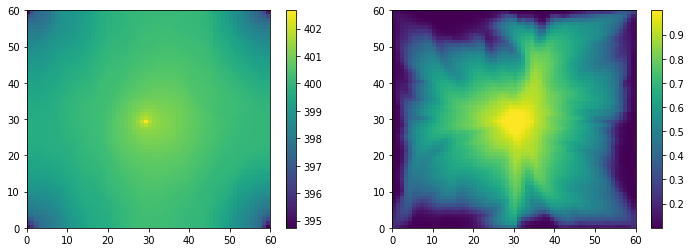

In [6]:
perm = load_single_keyword('data.in','PERMX')

m = Model(perm)
m.init()
m.run()
print("Simulation finished")

X = np.array(m.physics.engine.X, copy=False)
nb = m.nx * m.ny

p = X[0:2*nb:2]
z = X[1:2*nb:2]

plt.figure(num=2, figsize=(12,4))
plt.subplot(121)
plt.pcolor(p.reshape(m.ny, m.nx))
plt.colorbar()

plt.subplot(122)
plt.pcolor(z.reshape(m.ny, m.nx))
plt.colorbar()
plt.show()

<img style="float: left;" src="slides/Slide8.JPG" width="80%">

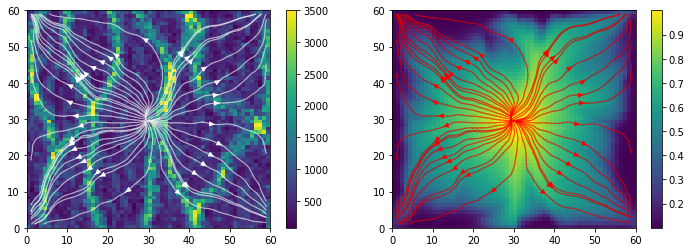

In [7]:
plt.figure(num=2, figsize=(12,4))
plt.subplot(121)
m.plot_streamline(p, m.permx, 'w')
plt.colorbar()

plt.subplot(122)
m.plot_streamline(p, z, 'r')
plt.colorbar()
plt.show()

<img style="float: left;" src="slides/Slide9.JPG" width="80%">

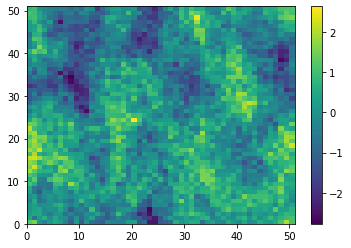

In [8]:
from scipy.io import loadmat
data = loadmat('model_1.mat')
realiz = np.array(data['realz'])
plt.pcolor(realiz)
plt.colorbar()

<img style="float: left;" src="slides/Slide10.JPG" width="80%">

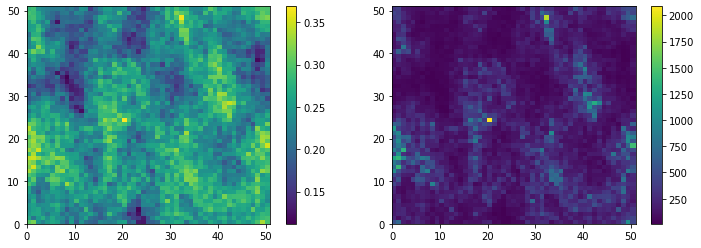

In [9]:
m=0.24
sigma=0.04
phi=m-np.mean(realiz)*(sigma/np.std(realiz))+realiz*(sigma/np.std(realiz))
k=10**(9*phi)


plt.figure(num=2, figsize=(12,4))
plt.subplot(121)
plt.pcolor(phi)
plt.colorbar()

plt.subplot(122)
plt.pcolor(k)
plt.colorbar()

<img style="float: left;" src="slides/Slide11.JPG" width="80%">

darts-package built on 08/10/2020 18:32:54 by root@runner-Gd7HMPkj-project-1205-concurrent-0 from 180bd2c
Building connection list...


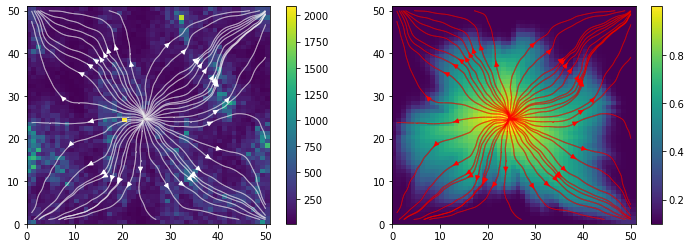

In [10]:
perm=k
m=Model(perm,nd=51)

m.init()
m.run()

#m.print_timers()

X = np.array(m.physics.engine.X, copy=False)
nb = m.nx * m.ny

p=X[0:2*nb:2]#pressure
z=X[1:2*nb:2]#composition
# plot solution
plt.figure(num=2, figsize=(12,4))
plt.subplot(121)
plt.pcolor(m.permx.reshape(m.ny, m.nx))
plt.colorbar()
m.plot_streamline(p,perm,col='w')

plt.subplot(122)
m.plot_streamline(p,perm)
plt.pcolor(z.reshape(m.ny, m.nx))
plt.colorbar()
plt.show()



<img style="float: left;" src="slides/Slide12.JPG" width="80%">

<font color='red'>Module 4.1 change the model to your own generated distribution of permeability; keep the same physical distance between wells as in the last practical</font> 

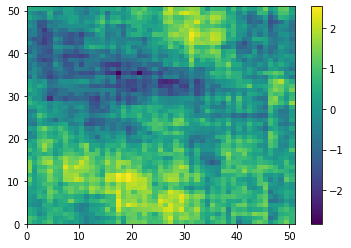

In [11]:
data = loadmat('model_group3.mat')
realiz = np.array(data['realz'])
plt.pcolor(realiz)
plt.colorbar()

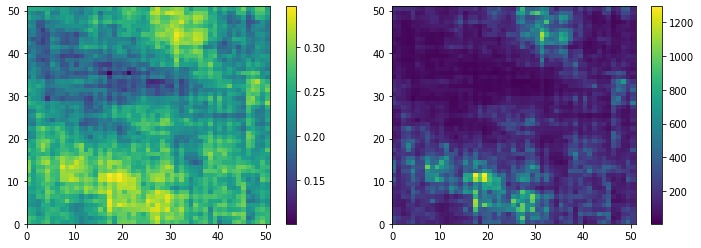

In [12]:
m=0.24
sigma=0.04
phi=m-np.mean(realiz)*(sigma/np.std(realiz))+realiz*(sigma/np.std(realiz))
k=10**(9*phi)


plt.figure(num=2, figsize=(12,4))
plt.subplot(121)
plt.pcolor(phi)
plt.colorbar()

plt.subplot(122)
plt.pcolor(k)
plt.colorbar()

<font color='red'>Module 4.2 plot solution and streamlines on top of porosity and composition maps after water breakthrough (run simulation for long enough time)</font> 

<font color='red'>Module 4.3 compare streamlines after breakthrough (item 2) and after only 3 days of simulation; explain results</font> 

darts-package built on 08/10/2020 18:32:54 by root@runner-Gd7HMPkj-project-1205-concurrent-0 from 180bd2c
Building connection list...
# 1 	T =   1	DT =  1	NI = 3	LI=15
# 2 	T =   3	DT =  2	NI = 2	LI=9
# 3 	T =   7	DT =  4	NI = 2	LI=10
# 4 	T =  15	DT =  8	NI = 2	LI=10
# 5 	T =  31	DT = 16	NI = 3	LI=17
# 6 	T =  63	DT = 32	NI = 3	LI=18
# 7 	T = 113	DT = 50	NI = 3	LI=20
# 8 	T = 163	DT = 50	NI = 3	LI=20
# 9 	T = 213	DT = 50	NI = 2	LI=13
# 10 	T = 263	DT = 50	NI = 2	LI=13
# 11 	T = 313	DT = 50	NI = 2	LI=13
# 12 	T = 363	DT = 50	NI = 2	LI=13
# 13 	T = 413	DT = 50	NI = 2	LI=13
# 14 	T = 463	DT = 50	NI = 2	LI=12
# 15 	T = 513	DT = 50	NI = 2	LI=13
# 16 	T = 563	DT = 50	NI = 2	LI=12
# 17 	T = 613	DT = 50	NI = 2	LI=13
# 18 	T = 663	DT = 50	NI = 2	LI=12
# 19 	T = 713	DT = 50	NI = 2	LI=11
# 20 	T = 763	DT = 50	NI = 2	LI=12
# 21 	T = 813	DT = 50	NI = 4	LI=16
# 22 	T = 863	DT = 50	NI = 2	LI=11
# 23 	T = 913	DT = 50	NI = 2	LI=12
# 24 	T = 963	DT = 50	NI = 2	LI=12
# 25 	T = 1000	DT = 37	NI = 1	LI=6
T

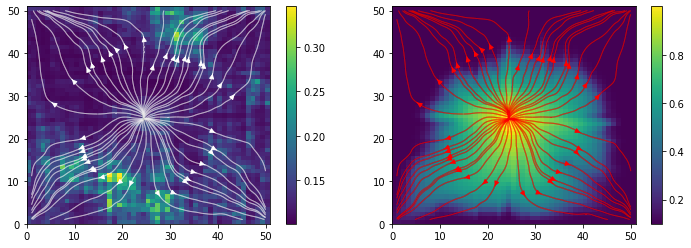

In [13]:
# Breakthrough
perm=k
m=Model(perm,nd=51)

m.init()
m.run_python() #1000 days

#m.print_timers()

X = np.array(m.physics.engine.X, copy=False)
nb = m.nx * m.ny

p=X[0:2*nb:2]#pressure
z=X[1:2*nb:2]#composition
# plot solution
plt.figure(num=2, figsize=(12,4))
plt.subplot(121)
plt.pcolor(phi)
plt.colorbar()
m.plot_streamline(p,perm,col='w')

plt.subplot(122)
m.plot_streamline(p,perm)
plt.pcolor(z.reshape(m.ny, m.nx))
plt.colorbar()
plt.show()

darts-package built on 08/10/2020 18:32:54 by root@runner-Gd7HMPkj-project-1205-concurrent-0 from 180bd2c
Building connection list...
# 1 	T =   1	DT =  1	NI = 3	LI=15
# 2 	T =   3	DT =  2	NI = 2	LI=9
TS = 2(0), NI = 5(0), LI = 24(0)


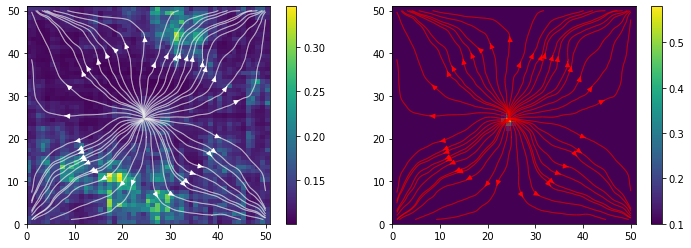

In [14]:
# after 3days

perm=k
m=Model(perm,nd=51)

m.init()
m.run_python(3) #3 days

#m.print_timers()

X = np.array(m.physics.engine.X, copy=False)
nb = m.nx * m.ny

p=X[0:2*nb:2]#pressure
z=X[1:2*nb:2]#composition
# plot solution
plt.figure(num=2, figsize=(12,4))
plt.subplot(121)
plt.pcolor(phi)
plt.colorbar()
m.plot_streamline(p,perm,col='w')

plt.subplot(122)
m.plot_streamline(p,perm)
plt.pcolor(z.reshape(m.ny, m.nx))
plt.colorbar()
plt.show()

<font color='green'>The top two images are after breakthrough (1000 days), this number has been determined by trial and error. The first breakthrough appears to be occuring in the bottom right corner. The bottom two images after only three days. There are not much differences apart from some slightly changing streamlines. Such as:

- The flow line that runs north in the breakthrough variant turns south in the 3day scenario.  
- the flow line that runs west runs further east in the three day scenario
- overal some flow lines appear to run into the reservoir wall earlier in the 3day scenario

The south part of the reservoir is more permeable than the north part (visible by the higher concentration of yellow-ness). By simulating the reservoir after 5000 days it can be observed how the flow lines change when most of the oil has been displaced.

</font> 



darts-package built on 08/10/2020 18:32:54 by root@runner-Gd7HMPkj-project-1205-concurrent-0 from 180bd2c
Building connection list...
# 1 	T =   1	DT =  1	NI = 3	LI=15
# 2 	T =   3	DT =  2	NI = 2	LI=9
# 3 	T =   7	DT =  4	NI = 2	LI=10
# 4 	T =  15	DT =  8	NI = 2	LI=10
# 5 	T =  31	DT = 16	NI = 3	LI=17
# 6 	T =  63	DT = 32	NI = 3	LI=18
# 7 	T = 113	DT = 50	NI = 3	LI=20
# 8 	T = 163	DT = 50	NI = 3	LI=20
# 9 	T = 213	DT = 50	NI = 2	LI=13
# 10 	T = 263	DT = 50	NI = 2	LI=13
# 11 	T = 313	DT = 50	NI = 2	LI=13
# 12 	T = 363	DT = 50	NI = 2	LI=13
# 13 	T = 413	DT = 50	NI = 2	LI=13
# 14 	T = 463	DT = 50	NI = 2	LI=12
# 15 	T = 513	DT = 50	NI = 2	LI=13
# 16 	T = 563	DT = 50	NI = 2	LI=12
# 17 	T = 613	DT = 50	NI = 2	LI=13
# 18 	T = 663	DT = 50	NI = 2	LI=12
# 19 	T = 713	DT = 50	NI = 2	LI=11
# 20 	T = 763	DT = 50	NI = 2	LI=12
# 21 	T = 813	DT = 50	NI = 4	LI=16
# 22 	T = 863	DT = 50	NI = 2	LI=11
# 23 	T = 913	DT = 50	NI = 2	LI=12
# 24 	T = 963	DT = 50	NI = 2	LI=12
# 25 	T = 1013	DT = 50	NI = 2	LI=12


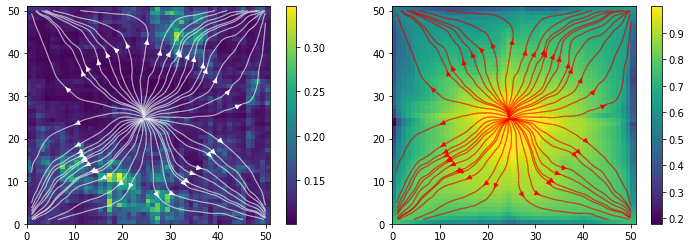

In [15]:
# after 5000days, well after breakthrough

perm=k
m=Model(perm,nd=51)

m.init()
m.run_python(5000) #3 days

#m.print_timers()

X = np.array(m.physics.engine.X, copy=False)
nb = m.nx * m.ny

p=X[0:2*nb:2]#pressure
z=X[1:2*nb:2]#composition
# plot solution
plt.figure(num=2, figsize=(12,4))

plt.subplot(121)
plt.pcolor(phi)
plt.colorbar()
m.plot_streamline(p,perm,col='w')

plt.subplot(122)
m.plot_streamline(p,perm)
plt.pcolor(z.reshape(m.ny, m.nx))
plt.colorbar()
plt.show()

<font color='green'>
when most of the oil is replaced it appears to follow 'shorter' lines. This means the route the water takes while flowing unhindered by the oil is straighter. This might be due to the water being more mobile than the oil and therefore, once a path has formed, this leads to this pattern.
</font> 



<font color='red'>'Module 4.4 change location of injector to (2/3 nx, 2/3 ny), and locate production wells along the horizontal and vertical lines passed through injector (here nx and ny are dimensions of the model'</font> 

<font color='red'>'Module 4.5 plot solutions and streamlines, explain why they look this way'</font> 

<font color='green'>
The new wells are   
    
    PRD1 = left 
    PRD2 = bottom 
    PRD3 = right  
    PRD4 = top 
    
<font>

In [41]:
class Model1(DartsModel):
    def __init__(self, perm=None, nd = 60, db = 8):
        # call base class constructor
        super().__init__()

        # measure time spend on reading/initialization
        self.timer.node["initialization"].start()

        # create reservoir
        self.nx = nd
        self.ny = nd
        self.nz = 1
        
        self.dx = db
        self.dy = db
        self.dz = 4

        if (perm is None):
            perm = np.ones(self.nx*self.ny)*300
        else:
            perm = perm.reshape(self.nx*self.ny)
            
        self.permx = perm
        self.permy = perm
        self.permz = 0.1 * perm
        self.poro = 0.2
        self.depth = 4000

        # run discretization
        self.reservoir = StructReservoir(self.timer, nx=self.nx, ny=self.ny, nz=self.nz, dx=self.dx, dy=self.dy,
                                         dz=self.dz, permx=self.permx, permy=self.permy, permz=self.permz,
                                         poro=self.poro, depth=self.depth)

        self.ix = np.int(self.nx / (3/2))
        self.iy = np.int(self.ny / (3/2))
        
        self.reservoir.add_well("INJ1")
        self.reservoir.add_perforation(self.reservoir.wells[-1], self.ix, self.iy, 1,  well_index=10)

        self.reservoir.add_well("PRD1")
        self.reservoir.add_perforation(self.reservoir.wells[-1], 1, self.iy, 1, well_index=10)

        self.reservoir.add_well("PRD2")
        self.reservoir.add_perforation(self.reservoir.wells[-1], self.ix, 1, 1, well_index=10)

        self.reservoir.add_well("PRD3")
        self.reservoir.add_perforation(self.reservoir.wells[-1], self.nx, self.iy, 1, well_index=10)
        
        self.reservoir.add_well("PRD4")
        self.reservoir.add_perforation(self.reservoir.wells[-1], self.ix, self.ny, 1, well_index=10)
        
        
        # create physics
        self.physics = DeadOil(timer=self.timer, physics_filename='physics.in',
                               n_points=401, min_p=300, max_p=600, min_z=1e-8)

        self.params.first_ts = 1
        self.params.mult_ts = 2
        self.params.max_ts = 50
        self.params.tolerance_newton = 1e-2
        self.params.tolerance_linear = 1e-3

        self.inj = [1]

        self.runtime = 1000

        self.timer.node["initialization"].stop()

    def set_initial_conditions(self):
        self.physics.set_uniform_initial_conditions(self.reservoir.mesh, uniform_pressure=400,
                                                    uniform_composition=[0.1])

    def set_boundary_conditions(self):
        for i, w in enumerate(self.reservoir.wells):
            if w.name[:3] == "INJ":
                w.control = self.physics.new_bhp_water_inj(410, self.inj)
                #w.constraint = self.physics.new_rate_water_prod(210)
            else:
                w.control = self.physics.new_bhp_prod(390)

    # This function plots streamlines based on passed pressure solution 
    # and permebility map from model class
    def plot_streamline(self, p, array, col='r'):

        P_2D = p.reshape(self.nx, self.ny)
        kx = self.permx.reshape(self.ny, self.nx)
        ky = self.permy.reshape(self.ny, self.nx)
        nvx, nvy = (self.nx-1, self.ny-1)

        v = np.zeros((nvx, nvy))
        u = np.zeros((nvx, nvy))
        ir, jr = (range(nvx), range(nvy))

        for i in ir:
            v[i, jr] = (kx[i, jr] + kx[i + 1, jr]) * (P_2D[i, jr] - P_2D[i + 1, jr])
        for j in jr:
            u[ir, j] = (ky[ir, j] + ky[ir, j + 1]) * (P_2D[ir, j] - P_2D[ir, j + 1])

        # find circle in 2D index array with radius r
        x = np.arange(0, nvx)
        y = np.arange(0, nvy)
        arr = np.zeros((nvx,nvy))
        r = 6. # make sure that the model is larger than [2r] * [2r]
        arr[(x[np.newaxis, :] - self.ix) ** 2 + (y[:, np.newaxis] - self.iy) ** 2 < r ** 2] = 1
        arr[(x[np.newaxis, :] - self.ix) ** 2 + (y[:, np.newaxis] - self.iy) ** 2 < (r-1) ** 2] = 0

        # starting points for streamlines
        sp = np.array(np.where(arr == 1))
        y, x = np.mgrid[1:nvy+1, 1:nvx+1]
        cont = plt.streamplot(x, y, u, v, density=100, color=col, linewidth=1, cmap='autumn', start_points=sp.T)

        array=array.reshape(self.ny, self.nx)
        plt.pcolor(array)

darts-package built on 08/10/2020 18:32:54 by root@runner-Gd7HMPkj-project-1205-concurrent-0 from 180bd2c
Building connection list...


/srv/conda/envs/notebook/lib/python3.7/site-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/srv/conda/envs/notebook/lib/python3.7/site-packages/ipykernel_launcher.py:35: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for addi

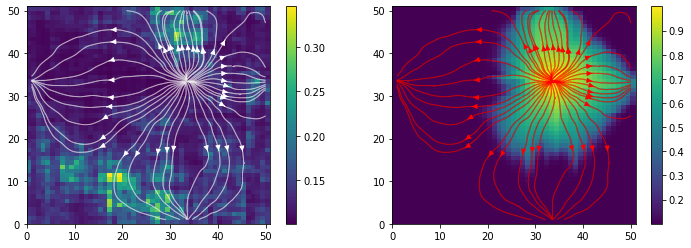

In [17]:
perm=k
m=Model1(perm,nd=51)

m.init()
m.run(1000)#3 days

#m.print_timers()

X = np.array(m.physics.engine.X, copy=False)
nb = m.nx * m.ny

p=X[0:2*nb:2]#pressure
z=X[1:2*nb:2]#composition
# plot solution
plt.figure(num=2, figsize=(12,4))
plt.title('3 days')
plt.subplot(121)
plt.pcolor(phi)
plt.colorbar()
m.plot_streamline(p,perm,col='w')

plt.subplot(122)
m.plot_streamline(p,perm)
plt.pcolor(z.reshape(m.ny, m.nx))
plt.colorbar()
plt.show()

<font color='green'>well number 4 at the top produces oil very easily as it is close to the injector well and connected to that injector by a fairly permeabile reservoir section. Well 1 and 2 however produce very little and will do so soon, see next figures after 4000 days. Even after 4000 days three wells produce a lot of water and only the left well (1) produces oil, but very little</font> 

darts-package built on 08/10/2020 18:32:54 by root@runner-Gd7HMPkj-project-1205-concurrent-0 from 180bd2c
Building connection list...


/srv/conda/envs/notebook/lib/python3.7/site-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/srv/conda/envs/notebook/lib/python3.7/site-packages/ipykernel_launcher.py:35: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for addi

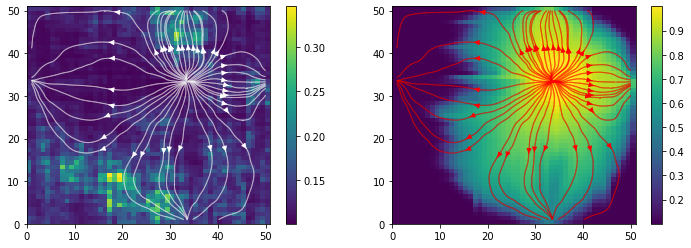

In [42]:
perm=k
m=Model1(perm,nd=51)

m.init()
m.run(4000) #days

#m.print_timers()

X = np.array(m.physics.engine.X, copy=False)
nb = m.nx * m.ny

p=X[0:2*nb:2]#pressure
z=X[1:2*nb:2]#composition
# plot solution
plt.figure(num=2, figsize=(12,4))
plt.title('3 days')
plt.subplot(121)
plt.pcolor(phi)
plt.colorbar()
m.plot_streamline(p,perm,col='w')

plt.subplot(122)
m.plot_streamline(p,perm)
plt.pcolor(z.reshape(m.ny, m.nx))
plt.colorbar()
plt.show()

<font color='red'>'Module 4.6 with appropiate well managment, balance the production in this system so breakthrough happend simultaneously. support your solution with appropriate graphs.'</font> 

In [33]:
class Model1(DartsModel):
    def __init__(self, perm=None, nd = 60, db = 8):
        # call base class constructor
        super().__init__()

        # measure time spend on reading/initialization
        self.timer.node["initialization"].start()

        # create reservoir
        self.nx = nd
        self.ny = nd
        self.nz = 1
        
        self.dx = db
        self.dy = db
        self.dz = 4

        if (perm is None):
            perm = np.ones(self.nx*self.ny)*300
        else:
            perm = perm.reshape(self.nx*self.ny)
            
        self.permx = perm
        self.permy = perm
        self.permz = 0.1 * perm
        self.poro = 0.2
        self.depth = 4000

        # run discretization
        self.reservoir = StructReservoir(self.timer, nx=self.nx, ny=self.ny, nz=self.nz, dx=self.dx, dy=self.dy,
                                         dz=self.dz, permx=self.permx, permy=self.permy, permz=self.permz,
                                         poro=self.poro, depth=self.depth)

        self.ix = np.int(self.nx / (3/2))
        self.iy = np.int(self.ny / (3/2))
        
        self.reservoir.add_well("INJ1")
        self.reservoir.add_perforation(self.reservoir.wells[-1], self.ix, self.iy, 1,  well_index=10)

        self.reservoir.add_well("PRD1")
        self.reservoir.add_perforation(self.reservoir.wells[-1], 1, self.iy, 1, well_index=10)

        self.reservoir.add_well("PRD2")
        self.reservoir.add_perforation(self.reservoir.wells[-1], self.ix, 1, 1, well_index=1)

        self.reservoir.add_well("PRD3")
        self.reservoir.add_perforation(self.reservoir.wells[-1], self.nx, self.iy, 1, well_index=0.05)
        
        self.reservoir.add_well("PRD4")
        self.reservoir.add_perforation(self.reservoir.wells[-1], self.ix, self.ny, 1, well_index=0.01)
        
        
        # create physics
        self.physics = DeadOil(timer=self.timer, physics_filename='physics.in',
                               n_points=401, min_p=300, max_p=600, min_z=1e-8)

        self.params.first_ts = 1
        self.params.mult_ts = 2
        self.params.max_ts = 50
        self.params.tolerance_newton = 1e-2
        self.params.tolerance_linear = 1e-3

        self.inj = [1]

        self.runtime = 1000

        self.timer.node["initialization"].stop()

    def set_initial_conditions(self):
        self.physics.set_uniform_initial_conditions(self.reservoir.mesh, uniform_pressure=400,
                                                    uniform_composition=[0.1])

    def set_boundary_conditions(self):
        for i, w in enumerate(self.reservoir.wells):
            if w.name[:3] == "INJ":
                w.control = self.physics.new_bhp_water_inj(410, self.inj)
                #w.constraint = self.physics.new_rate_water_prod(210)
            else:
                w.control = self.physics.new_bhp_prod(390)

    # This function plots streamlines based on passed pressure solution 
    # and permebility map from model class
    def plot_streamline(self, p, array, col='r'):

        P_2D = p.reshape(self.nx, self.ny)
        kx = self.permx.reshape(self.ny, self.nx)
        ky = self.permy.reshape(self.ny, self.nx)
        nvx, nvy = (self.nx-1, self.ny-1)

        v = np.zeros((nvx, nvy))
        u = np.zeros((nvx, nvy))
        ir, jr = (range(nvx), range(nvy))

        for i in ir:
            v[i, jr] = (kx[i, jr] + kx[i + 1, jr]) * (P_2D[i, jr] - P_2D[i + 1, jr])
        for j in jr:
            u[ir, j] = (ky[ir, j] + ky[ir, j + 1]) * (P_2D[ir, j] - P_2D[ir, j + 1])

        # find circle in 2D index array with radius r
        x = np.arange(0, nvx)
        y = np.arange(0, nvy)
        arr = np.zeros((nvx,nvy))
        r = 6. # make sure that the model is larger than [2r] * [2r]
        arr[(x[np.newaxis, :] - self.ix) ** 2 + (y[:, np.newaxis] - self.iy) ** 2 < r ** 2] = 1
        arr[(x[np.newaxis, :] - self.ix) ** 2 + (y[:, np.newaxis] - self.iy) ** 2 < (r-1) ** 2] = 0

        # starting points for streamlines
        sp = np.array(np.where(arr == 1))
        y, x = np.mgrid[1:nvy+1, 1:nvx+1]
        cont = plt.streamplot(x, y, u, v, density=100, color=col, linewidth=1, cmap='autumn', start_points=sp.T)

        array=array.reshape(self.ny, self.nx)
        plt.pcolor(array)


<font color='green'>after 1500 days</font> 

darts-package built on 08/10/2020 18:32:54 by root@runner-Gd7HMPkj-project-1205-concurrent-0 from 180bd2c
Building connection list...


/srv/conda/envs/notebook/lib/python3.7/site-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/srv/conda/envs/notebook/lib/python3.7/site-packages/ipykernel_launcher.py:35: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for addi

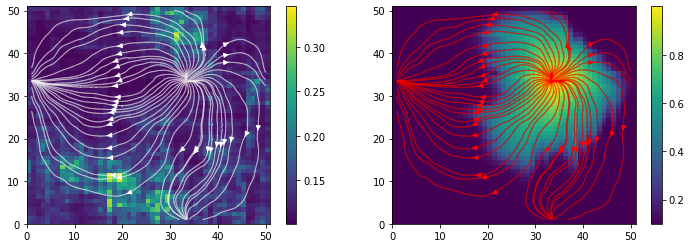

In [34]:
perm=k
m=Model1(perm,nd=51)

m.init()
m.run(1500) #days

#m.print_timers()

X = np.array(m.physics.engine.X, copy=False)
nb = m.nx * m.ny

p=X[0:2*nb:2]#pressure
z=X[1:2*nb:2]#composition
# plot solution
plt.figure(num=2, figsize=(12,4))
plt.subplot(121)
plt.pcolor(phi)
plt.colorbar()
m.plot_streamline(p,perm,col='w')

plt.subplot(122)
m.plot_streamline(p,perm)
plt.pcolor(z.reshape(m.ny, m.nx))
plt.colorbar()
plt.show()

<font color='green'>after 2000 days</font> 

darts-package built on 08/10/2020 18:32:54 by root@runner-Gd7HMPkj-project-1205-concurrent-0 from 180bd2c
Building connection list...


/srv/conda/envs/notebook/lib/python3.7/site-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/srv/conda/envs/notebook/lib/python3.7/site-packages/ipykernel_launcher.py:35: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for addi

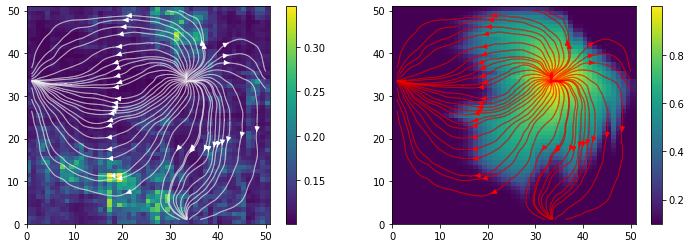

In [35]:
perm=k
m=Model1(perm,nd=51)

m.init()
m.run(2000) #days

#m.print_timers()

X = np.array(m.physics.engine.X, copy=False)
nb = m.nx * m.ny

p=X[0:2*nb:2]#pressure
z=X[1:2*nb:2]#composition
# plot solution
plt.figure(num=2, figsize=(12,4))
plt.title('1000 days, balanced')
plt.subplot(121)
plt.pcolor(phi)
plt.colorbar()
m.plot_streamline(p,perm,col='w')

plt.subplot(122)
m.plot_streamline(p,perm)
plt.pcolor(z.reshape(m.ny, m.nx))
plt.colorbar()
plt.show()

<font color='green'>after 2500 days</font> 

darts-package built on 08/10/2020 18:32:54 by root@runner-Gd7HMPkj-project-1205-concurrent-0 from 180bd2c
Building connection list...


/srv/conda/envs/notebook/lib/python3.7/site-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/srv/conda/envs/notebook/lib/python3.7/site-packages/ipykernel_launcher.py:35: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for addi

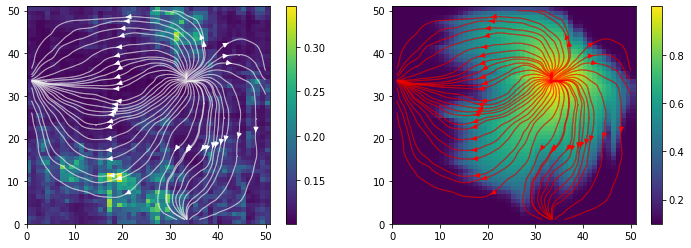

In [36]:
perm=k
m=Model1(perm,nd=51)

m.init()
m.run(2500) #days

#m.print_timers()

X = np.array(m.physics.engine.X, copy=False)
nb = m.nx * m.ny

p=X[0:2*nb:2]#pressure
z=X[1:2*nb:2]#composition
# plot solution
plt.figure(num=2, figsize=(12,4))
plt.title('1000 days, balanced')
plt.subplot(121)
plt.pcolor(phi)
plt.colorbar()
m.plot_streamline(p,perm,col='w')

plt.subplot(122)
m.plot_streamline(p,perm)
plt.pcolor(z.reshape(m.ny, m.nx))
plt.colorbar()
plt.show()

<font color='green'>after 3000 days</font> 

darts-package built on 08/10/2020 18:32:54 by root@runner-Gd7HMPkj-project-1205-concurrent-0 from 180bd2c
Building connection list...


/srv/conda/envs/notebook/lib/python3.7/site-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/srv/conda/envs/notebook/lib/python3.7/site-packages/ipykernel_launcher.py:35: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for addi

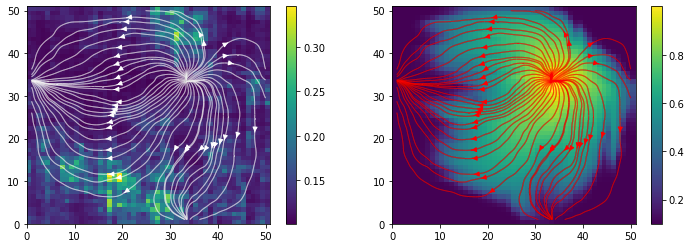

In [38]:
perm=k
m=Model1(perm,nd=51)

m.init()
m.run(3000) # days

#m.print_timers()

X = np.array(m.physics.engine.X, copy=False)
nb = m.nx * m.ny

p=X[0:2*nb:2]#pressure
z=X[1:2*nb:2]#composition
# plot solution
plt.figure(num=2, figsize=(12,4))
plt.title('1000 days, balanced')
plt.subplot(121)
plt.pcolor(phi)
plt.colorbar()
m.plot_streamline(p,perm,col='w')

plt.subplot(122)
m.plot_streamline(p,perm)
plt.pcolor(z.reshape(m.ny, m.nx))
plt.colorbar()
plt.show()

darts-package built on 08/10/2020 18:32:54 by root@runner-Gd7HMPkj-project-1205-concurrent-0 from 180bd2c
Building connection list...


/srv/conda/envs/notebook/lib/python3.7/site-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/srv/conda/envs/notebook/lib/python3.7/site-packages/ipykernel_launcher.py:35: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for addi

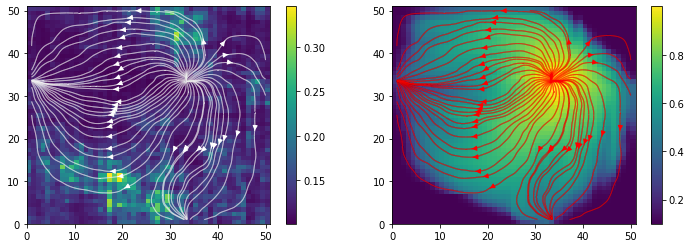

In [40]:
perm=k
m=Model1(perm,nd=51)

m.init()
m.run(4000) #days

#m.print_timers()

X = np.array(m.physics.engine.X, copy=False)
nb = m.nx * m.ny

p=X[0:2*nb:2]#pressure
z=X[1:2*nb:2]#composition
# plot solution
plt.figure(num=2, figsize=(12,4))
plt.title('1000 days, balanced')
plt.subplot(121)
plt.pcolor(phi)
plt.colorbar()
m.plot_streamline(p,perm,col='w')

plt.subplot(122)
m.plot_streamline(p,perm)
plt.pcolor(z.reshape(m.ny, m.nx))
plt.colorbar()
plt.show()

<font color='green'>
The new wells are   
    
    PRD1 = left 
    PRD2 = bottom 
    PRD3 = right  
    PRD4 = top 
    
By balancing 
    
    PRD1 = 10 
    PRD2 = 1 
    PRD3 = 0.05 
    PRD4 = 0.01 
    
The breakthrough happens more or less at the same moment after about 4000 days. This means that production well 3 and 4 are almost shutdown to prevent production. Especially the left well (PRD1) has trouble producing as it is located in a fairly low permeable section of the reservoir. By the pinching off of the other wells most of the production happens in well 1 and after that well 2. Well 3 and especially 4 produces almost no oil.
    
A solution to the problem might be producing well 3/4 first, until breakthrough happens, shutting 3/4 down and start well 1/2 to draw the entire reservoir.

</font> 